# Satellite AOD data resolution assessment for pollution hotspot indentification
&nbsp;

Production date: 30-09-2024

Produced by: Consiglio Nazionale delle Ricerche (CNR)

## 🌍 Use Case: Identification of Pollution Hotspots
## ❓ Quality assessment question

**• Does the satellite AOD data resolution allow us to identify pollution hotspots such as megacities?**

The “satellite-aerosol-properties” catalog provides global information on aerosol optical depth (AOD) and fine-mode aerosol optical depth (FMAOD) from 1995 to the present, derived from satellite observations. The SLSTR dataset is used in the following analysis to identify signatures of pollution in certain areas.

Near-surface aerosols can seriously endanger human health, particularly in “megacities.” The aerosol optical depth (AOD) measures the extinction of solar radiation due to aerosols and, in the boundary layer, is often adopted as an indicator of local air pollution. Over the last few decades, the Mediterranean has experienced rapid growth in urbanization, vehicle use, and industrialization, which has been reflected in increased pollutant emissions into the atmosphere. The eastern basin of the Mediterranean and the surrounding regions include two megacities: Cairo (>15 million inhabitants, Egypt) [1] at the southern edge of the basin and Istanbul [2] (>12 million inhabitants, Turkey) at the northeastern edge, as well as several large urban centers such as Athens [3] (>4 million inhabitants) in Greece. The health effects of interactions between pollutants and photochemical oxidants can be exacerbated in the Mediterranean under conditions of high temperature and humidity. According to literature dating back to 1999, Cairo has experienced recurring air pollution incidents known as the “black cloud” phenomenon during the autumn season. These occurrences have been attributed to two primary factors: the burning of agricultural waste and the long-distance transport of desert dust [4]. Research suggests that while dust aerosols contribute to elevated air pollution levels during the fall, the primary factor behind the black cloud pollution is the biomass burning of agricultural waste [1], [5]. Given that higher AOD values generally reflect greater concentrations of particulate matter in the atmosphere, indicating higher levels of air pollution [6], this notebook concludes that the resolution of satellite AOD data is adequate for identifying pollution hotspots, particularly in megacities.

## 📢 Quality Assessment Statement
The Sentinel-3 satellite AOD data resolution can identify pollution hotspots, such as megacities.

The spatial map of AOD and FMAOD over the East Mediterranean for 2017–2022 identified the high AOD values in regions where there are megacities, such as Cairo in Egypt. In order to further investigate the AOD 550 and FMAOD 550 nm concentrations in Cairo and the surrounding area, we plotted on a monthly time aggregation the spatially weighted mean timeseries of AOD for these two areas. Monthly averages of AOD and FMAOD in Cairo (latitude: 30.033° N, longitude: 31.233° E, altitude: close to sea level). Compared to those in a nearby location, Tanta showed that AOD and FMAOD are much higher in Cairo. The effect of the most relevant dust outbreaks occurs at the mesoscale; therefore, the presented results showed the contrast between a town and a megacity, both affected by mineral dust, but with a higher pollution concentration in Cairo, as also outlined in the literature [6]. Therefore, the AOD data resolution allows us to identify pollution hotspots depending on their intensities.

### 📋 Methodology

In order to identify pollution hotspots (e.g., megacities) from column AOD measurements in a specific Area of Interest (AoI), spatial maps of the AOD have been created using the AOD and fine-mode AOD (FMAOD) product measured at 550 nm over the Eastern basin of the Mediterranean and the surrounding regions. The AOD values in a heavily populated area, Cairo (latitude: 30.033° N, longitude: 31.233° E, altitude: close to sea level), have been compared with the values in a surrounding area, Tanta, a nearby town out 94 km north of Cairo. The comparison has been based on monthly averages of the AOD and FMAOD over two AoIs, one in correspondence with the polluted hotspot and the other in a cleaner region.

The analysis and results are organised in the following steps, which are detailed in the sections below:

• Data Collection and Preprocessing: Download AOD and Fine_AOD data (AOD550 and FM_AOD550 from "Aerosol properties gridded data from 1995 to present derived from satellite observations," horizontal resolution: 1° x 1°; temporal resolution: monthly).

• Data Transformation and Merging: Data from both versions were aggregated monthly and converted into a unified format, allowing the two versions to be combined seamlessly. This provided a comprehensive dataset covering the period from July 2017 to December 2022.

• Calculate and plot the merged seasonal mean of AOD 550 nm and FMAOD 550 nm for the determined period: Seasonal averages for AOD were calculated for each season: Winter (DJF), Spring (MAM), Summer (JJA), and Autumn (SON). This step was crucial for identifying temporal patterns in aerosol concentrations across the region.

• Setting up the data request and downloading the monthly average dataset for versions v2.1 and v2.2, and defining latitude and longitude for “Cairo” and “Tanta.”

• Plot the monthly AOD 550 nm and Fine Mode AOD 550 nm time series for a single megacity (Cairo) and the nearby area (Tanta).


This assessment covers the following parts:

Spatial mapping of AOD550 and FM_AOD550 over the Eastern Mediterranean for 2017–2022.

Seasonal trend analysis of AOD550 and FM_AOD for "Cairo" and its nearby town, "Tanta."
 


## 📈 Analysis and Results

(template:section-1)=
### 1. Download, Convert, and Combine AOD and Fine_AOD Data
Packages that were requested have been imported. The request was defined, and data was downloaded.
The time dimension for both versions was converted and redefined to ensure consistency.
The two monthly datasets (AOD and Fine_AOD) were combined along the version dimension to create a unified dataset for further analysis.

In [7]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.dates as mdates  
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xarray as xr
import pandas as pd
from c3s_eqc_automatic_quality_control import diagnostics, download, plot, utils
import warnings
warnings.filterwarnings("ignore")


from c3s_eqc_automatic_quality_control import download

collection_id = "satellite-aerosol-properties"
request = {
    "format": "zip",
    "time_aggregation": "monthly_average",
    "variable": "aerosol_optical_depth",
    "sensor_on_satellite": "slstr_on_sentinel_3a",
    "algorithm": "ens",
}

time_dict = {
    "v2.1": {"start": "2017-07", "stop": "2020-06"},
    "v2.2": {"start": "2020-07", "stop": "2022-12"},
}

#eastern mediterranean sea
lon_slice = slice(15.8, 43.3)
lat_slice = slice(26.4, 43.1)

ds_dict = {}
for version, kwargs in time_dict.items():
    requests = download.update_request_date(
        request | {"version": version}, **kwargs, stringify_dates=True
    )
    ds_dict[version] = download.download_and_transform(
        collection_id, requests, chunks={"year": 1, "month": 1}
    )


100%|██████████| 30/30 [00:00<00:00, 37.93it/s]


(template:section-2)=
### 2. Data Transformation and Merging
Data from both versions were aggregated monthly and converted into a unified format, allowing the two versions to be combined seamlessly. This provided a comprehensive dataset covering the period from July 2017 to December 2022. 

In [8]:
ds_monthly_dict = {}


for version, ds in ds_dict.items():
   
    ds_monthly = ds.copy()

   
    ds_monthly["source"] = ds_monthly["source"].str.slice(None, 6)
    ds_monthly["source"] = pd.to_datetime(ds_monthly["source"], format="%Y%m")

    ds_monthly = ds_monthly.rename({'source': 'time'})

  
    ds_monthly = utils.regionalise(ds_monthly, lon_slice=lon_slice, lat_slice=lat_slice)


    ds_monthly_dict[version] = ds_monthly

for version, ds_monthly in ds_monthly_dict.items():
    print(f"Version {version}:")
    print(ds_monthly)


ds_monthly_merged = xr.concat([ds_monthly_dict['v2.1'],ds_monthly_dict['v2.2']], dim='time')


Version v2.1:
<xarray.Dataset> Size: 265kB
Dimensions:                      (time: 36, latitude: 17, longitude: 27)
Coordinates:
  * time                         (time) datetime64[ns] 288B 2017-07-01 ... 20...
  * latitude                     (latitude) float32 68B 26.5 27.5 ... 41.5 42.5
  * longitude                    (longitude) float32 108B 16.5 17.5 ... 42.5
Data variables:
    AOD550                       (time, latitude, longitude) float32 66kB dask.array<chunksize=(1, 17, 27), meta=np.ndarray>
    FM_AOD550                    (time, latitude, longitude) float32 66kB dask.array<chunksize=(1, 17, 27), meta=np.ndarray>
    AOD550_UNCERTAINTY_ENSEMBLE  (time, latitude, longitude) float32 66kB dask.array<chunksize=(1, 17, 27), meta=np.ndarray>
    NMEAS                        (time, latitude, longitude) float32 66kB dask.array<chunksize=(1, 17, 27), meta=np.ndarray>
Attributes: (12/18)
    Conventions:               CF-1.6
    creator_email:             thomas.popp@dlr.de
    creat

(template:section-3)=

### 3. Calculate and Plot the Merged Seasonal Mean of AOD 550 nm and FMAOD 550 nm
Seasonal averages for AOD and FMAOD were calculated for each season: Winter (DJF), Spring (MAM), Summer (JJA), and Autumn (SON). This step was crucial for identifying temporal patterns in aerosol concentrations across the region, and the two versions were merged.




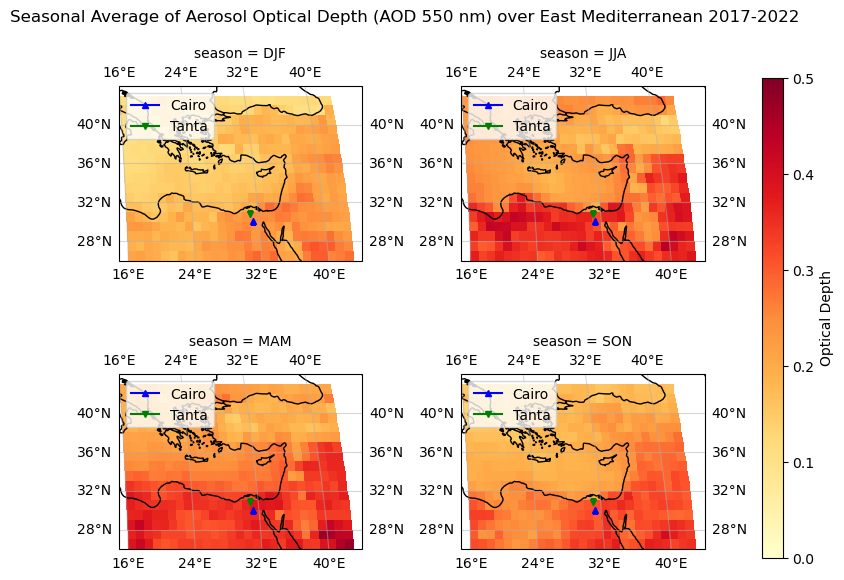

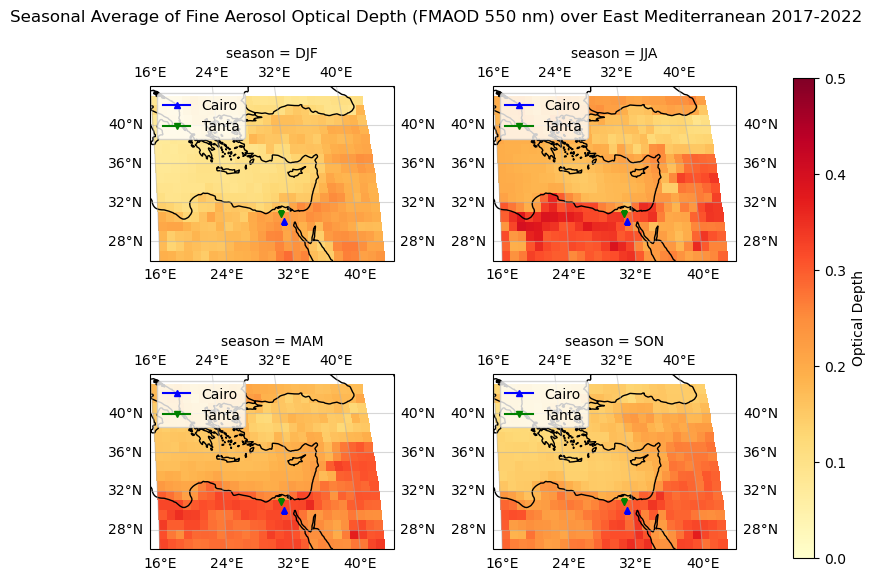

In [11]:
ds_seas_merged = ds_monthly_merged.groupby('time.season').mean()
print(ds_seas_merged)


# Coordinates for Cairo and Tanta
cairo_coords = (31.2357, 30.0444)  # (longitude, latitude)
tanta_coords = (31.0004, 30.7865)  # (longitude, latitude)

# AOD Plot
map_proj = ccrs.Robinson()

p = ds_seas_merged["AOD550"].plot.pcolormesh(cmap='YlOrRd', vmax=0.5, vmin=0, col="season", col_wrap=2,
                                             transform=ccrs.PlateCarree(),
                                             subplot_kws={"projection": map_proj},
                                             add_colorbar=False)

for ax in p.axes.flat:
    ax.coastlines()
    ax.set_extent([16, 44, 26, 44], crs=ccrs.PlateCarree())
    
    gl = ax.gridlines(draw_labels=True, alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    gl.xlocator = plt.MaxNLocator(5)
    gl.ylocator = plt.MaxNLocator(5)
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    
    # Plot smaller triangle markers for Cairo and Tanta
    ax.plot(cairo_coords[0], cairo_coords[1], marker='^', color='blue', markersize=5, 
            transform=ccrs.PlateCarree(), label='Cairo')  # Upward triangle for Cairo
    ax.plot(tanta_coords[0], tanta_coords[1], marker='v', color='green', markersize=5, 
            transform=ccrs.PlateCarree(), label='Tanta')  # Downward triangle for Tanta

    # Add legend
    ax.legend(loc='upper left')

mappable = p.axes[0][0].collections[0]

cax = plt.axes([1, 0.1, 0.03, 0.8])
cbar = plt.colorbar(mappable, cax=cax)
cbar.set_label('Optical Depth')
plt.title(label="Seasonal Average of Aerosol Optical Depth (AOD 550 nm) over East Mediterranean 2017-2022", x=-17, y=1.1)
plt.tight_layout()

plt.show()

# FMAOD Plot
map_proj = ccrs.Robinson()

p = ds_seas_merged["FM_AOD550"].plot.pcolormesh(cmap='YlOrRd', vmax=0.5, vmin=0, col="season", col_wrap=2,
                                                transform=ccrs.PlateCarree(),
                                                subplot_kws={"projection": map_proj},
                                                add_colorbar=False)

for ax in p.axes.flat:
    ax.coastlines()
    ax.set_extent([16, 44, 26, 44], crs=ccrs.PlateCarree())
    
    gl = ax.gridlines(draw_labels=True, alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    gl.xlocator = plt.MaxNLocator(5)
    gl.ylocator = plt.MaxNLocator(5)
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    
    # Plot smaller triangle markers for Cairo and Tanta
    ax.plot(cairo_coords[0], cairo_coords[1], marker='^', color='blue', markersize=5, 
            transform=ccrs.PlateCarree(), label='Cairo')  # Upward triangle for Cairo
    ax.plot(tanta_coords[0], tanta_coords[1], marker='v', color='green', markersize=5, 
            transform=ccrs.PlateCarree(), label='Tanta')  # Downward triangle for Tanta

    # Add legend
    ax.legend(loc='upper left')

mappable = p.axes[0][0].collections[0]

cax = plt.axes([1, 0.1, 0.03, 0.8])
cbar = plt.colorbar(mappable, cax=cax)
cbar.set_label('Optical Depth')
plt.title(label="Seasonal Average of Fine Aerosol Optical Depth (FMAOD 550 nm) over East Mediterranean 2017-2022", x=-17, y=1.1)
plt.tight_layout()

plt.show()


The figures show the presence of the megacities of Cairo, Istanbul, and Athens. In order to further investigate the AOD 550 nm concentration in Cairo and the nearby area, we will plot on a monthly time aggregation the spatially weighted mean timeseries of AOD for these two areas. 

(template:section-4)=
### 4. Setting up the data request and downloading the monthly average dataset for the versions v2.1 and v2.2 and define latitude and longitude for "Cairo" and "Tanta".

a. Setting up the data request, downloading

b. Define functions to calculate the seasonal mean of AOD and FMAOD for the determined period.

c. Download the monthly and spatially weighted mean AOD and FMAOD for Cairo.

d. Download the monthly and spatially weighted mean AOD and FMAOD for Tanta.

In [15]:
from c3s_eqc_automatic_quality_control import download

collection_id = "satellite-aerosol-properties"
request2 = {
    "format": "zip",
    "time_aggregation": "monthly_average",
    "variable": "aerosol_optical_depth",
    "sensor_on_satellite": "slstr_on_sentinel_3a",
    "algorithm": "ens",
}

time_dict = {
       "v2.1": {"start": "2018-11", "stop": "2020-06"},
       "v2.2": {"start": "2020-07", "stop": "2022-06"},
}
lon_slicecairo= slice(31.22, 32)
lat_slicecairo = slice(29, 30.3)

lon_slicetanta= slice(30.94, 31.5)
lat_slicetanta = slice(31, 32)




def source_to_time_monthly(ds):
    # Naming convention: YYYYMM-*.nc
    ds["source"] = pd.to_datetime(ds["source"].str.slice(None, 6), format="%Y%m")
    return ds.rename(source="time")


def source_to_time_monthly_and_spatial_weighted_mean(ds):
    ds = ds.set_coords("source") 
    ds = utils.regionalise(ds, lon_slice=lon_slicecairo, lat_slice=lat_slicecairo)
    return diagnostics.spatial_weighted_mean(source_to_time_monthly(ds))

def source_to_time_monthly_and_spatial_weighted_mean1(ds):
    ds = ds.set_coords("source")  
    ds = utils.regionalise(ds, lon_slice=lon_slicetanta, lat_slice=lat_slicetanta)
    return diagnostics.spatial_weighted_mean(source_to_time_monthly(ds))





ds_dictcairo = {}
for version, kwargs in time_dict.items():
    requests2 = download.update_request_date(
        request2 | {"version": version}, **kwargs, stringify_dates=True
    )
    ds_dictcairo[version] = download.download_and_transform(
        collection_id, requests2, 
    transform_func=source_to_time_monthly_and_spatial_weighted_mean,
        split_all=True,
    )

final_dataset = xr.merge(list(ds_dictcairo.values()))




ds_dicttanta = {}
for version, kwargs in time_dict.items():
    requests2 = download.update_request_date(
        request2 | {"version": version}, **kwargs, stringify_dates=True
    )
    ds_dicttanta[version] = download.download_and_transform(
        collection_id, requests2, 
    transform_func=source_to_time_monthly_and_spatial_weighted_mean1,
    split_all=True,)
    

final_dataset2 = xr.merge(list(ds_dicttanta.values()))




100%|██████████| 730/730 [00:23<00:00, 31.55it/s]


(template:section-5)=
### 5. Plot the monthly AOD 550 nm and Fine Mode AOD 550 nm time series for a single megacity (Cairo) and the nearby area (Tanta). 
 The figures show the spatially weighted mean timeseries of AOD and FMAOD at 550 nm and the related seasonal variability in the selected area. High seasonal mean values are displayed on the maps of the AOD and FMAOD for Cairo, in agreement with the condition of a megacity. The analysis of the SLSTR dataset also reveals that AOD in Cairo is larger than in Tanta, a nearby town located 94 km north of Cairo. The effect of the most relevant dust outbreaks occurs at the mesoscale; therefore, the presented results show the contrast between a town and a megacity, both affected by mineral dust, but with a higher pollution concentration in Cairo, as also outlined in the literature.


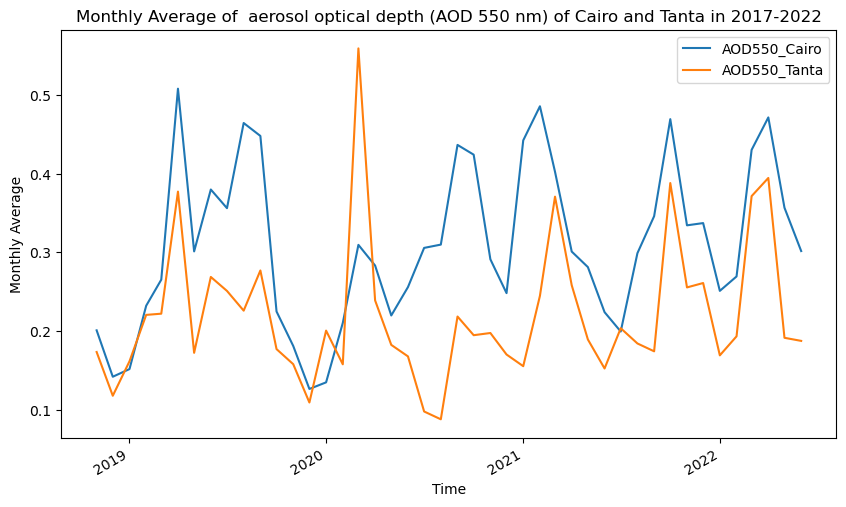

In [17]:
import matplotlib.pyplot as plt
import numpy as np
t = final_dataset["time"] 


# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

y1 = final_dataset['AOD550']
plt.plot(t, y1, label="AOD550_Cairo")

y2 = final_dataset2['AOD550']
plt.plot(t, y2, label="AOD550_Tanta")

ax.set_xlabel('Time')
ax.set_ylabel('Monthly Average')
ax.set_title('Monthly Average of  aerosol optical depth (AOD 550 nm) of Cairo and Tanta in 2017-2022')
ax.legend()

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(fontsize=10)

fig.autofmt_xdate()
plt.show()

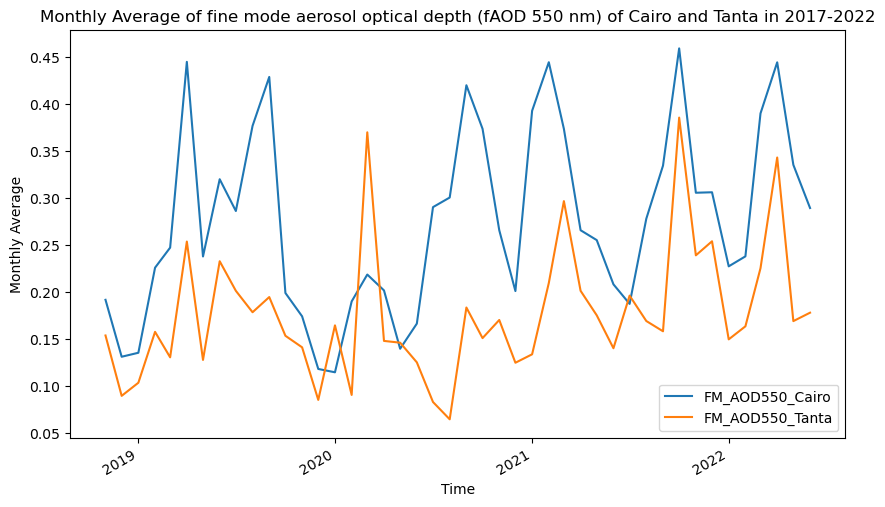

In [18]:
import matplotlib.pyplot as plt
import numpy as np
t = final_dataset["time"] 


# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

y1 = final_dataset['FM_AOD550']
plt.plot(t, y1, label="FM_AOD550_Cairo")

y2 = final_dataset2['FM_AOD550']
plt.plot(t, y2, label="FM_AOD550_Tanta")

ax.set_xlabel('Time')
ax.set_ylabel('Monthly Average')
ax.set_title('Monthly Average of fine mode aerosol optical depth (FMAOD 550 nm) of Cairo and Tanta in 2017-2022')
ax.legend()

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


plt.xticks(fontsize=10)

fig.autofmt_xdate()
plt.show()

### References
1. Favez, O., Cachier, H., Sciare, J., Alfaro, S.C., El-Araby, T.M., Harhash, M.A. and Abdelwahab, M.M., 2008. Seasonality of major aerosol species and their transformations in Cairo megacity. Atmospheric Environment, 42(7), pp.1503-1516.
2. Flores, R.M., Özdemir, H., Ünal, A. and Tayanc, M., 2022. Distribution and sources of SVOCs in fine and coarse aerosols in the megacity of Istanbul. Atmospheric Research, 271, p.106100.
3. Kanakidou, M., Mihalopoulos, N., Kindap, T., Im, U., Vrekoussis, M., Gerasopoulos, E., Dermitzaki, E., Unal, A., Koçak, M., Markakis, K. and Melas, D., 2011. Megacities as hot spots of air pollution in the East Mediterranean. Atmospheric Environment, 45(6), pp.1223-1235.
4. Marey, H.S., Gille, J.C., El-Askary, H.M., Shalaby, E.A. and El-Raey, M.E., 2011. Aerosol climatology over Nile Delta based on MODIS, MISR and OMI satellite data. Atmospheric Chemistry and Physics, 11(20), pp.10637-10648.
5. Steiner, A.L., Tawfik, A.B., Shalaby, A., Zakey, A.S., Abdel-Wahab, M.M., Salah, Z., Solmon, F., Sillman, S. and Zaveri, R.A., 2014. Climatological simulations of ozone and atmospheric aerosols in the Greater Cairo region. Climate research, 59(3), pp.207-228.
6. Zhao, D., Xin, J., Gong, C., Quan, J., Liu, G., Zhao, W., Wang, Y., Liu, Z. and Song, T., 2019. The formation mechanism of air pollution episodes in Beijing city: Insights into the measured feedback between aerosol radiative forcing and the atmospheric boundary layer stability. Science of the Total Environment, 692, pp.371-381.
7. Pappalardo, G., Wandinger, U., Mona, L., Hiebsch, A., Mattis, I., Amodeo, A., Ansmann, A., Seifert, P., Linné, H., Apituley, A. and Alados Arboledas, L., 2010. EARLINET correlative measurements for CALIPSO: First intercomparison results. Journal of Geophysical Research: Atmospheres, 115(D4).